In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from mlp import audio
from mlp import normalization
from mlp import utils as mlp
import IPython.display as ipd
from mlp.dataset import WAVAudioDS, PolarPreprocessing
from multiprocessing import Pool
import pickle
from torch.utils.data import DataLoader
import math
import torch

In [2]:
fs = 48000
bs = 1
stroke_width = 32
patch_width = 128
patch_height = 64
nperseg = 256

val_files = pickle.load(open("valid.pk", "rb"))

In [3]:
stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width, fs, nperseg)
purge_mask = stroke_mask.float()

In [4]:
preprocess = PolarPreprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width,
    patch_height
)

torch.multiprocessing.set_sharing_strategy('file_system') # I was getting memory errors without this line.
with Pool(8) as p:
    ds_valid = WAVAudioDS(files=val_files, mk_source=lambda x: x * purge_mask, preprocess=preprocess, 
                          patch_width=patch_width, proc_pool=p, nperseg=256, random_patches=False) 
    
dl_valid = DataLoader(ds_valid, batch_size=bs, num_workers=8, shuffle=False)

Interpolation


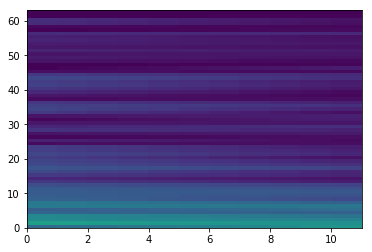

Original


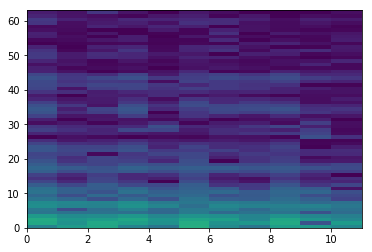

Interpolation


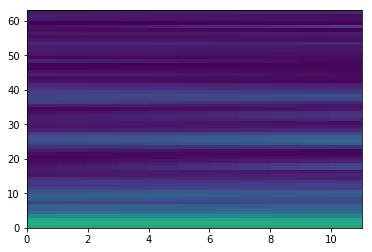

Original


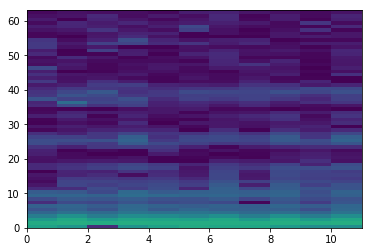

Interpolation


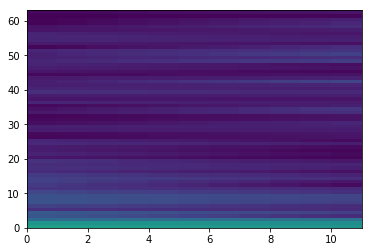

Original


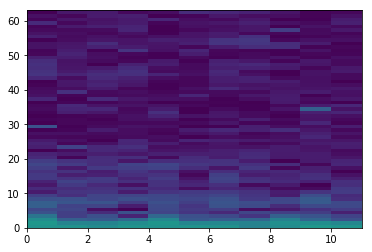

Interpolation


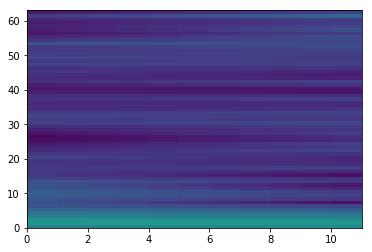

Original


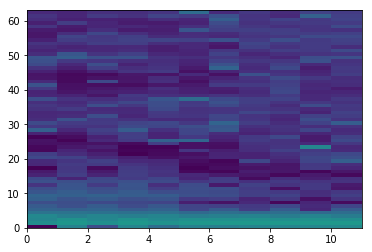

Interpolation


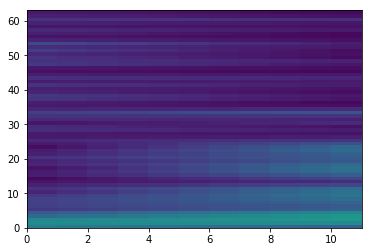

Original


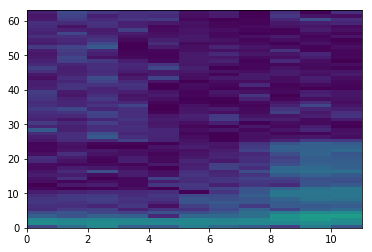

Bilinear Interpolation
MSE: 0.13984029138644555
MSE std: 0.053255255732793556


In [5]:
pixels = math.floor(stroke_width * (1 / 500) * (fs / nperseg))
left_offset = patch_width // 2 - pixels // 2

f = list(range(patch_height))
t_train = list(range(left_offset)) + list(range(left_offset+pixels, patch_width))
t_test = list(range(left_offset, left_offset+pixels))
mse_list = []

for i, patch in enumerate(dl_valid):
    magnitude = patch[0].squeeze(0)
    train = np.abs(magnitude[0,:,t_train].numpy())
    interp = interpolate.interp2d(t_train, f, train, kind='linear')
    pred = np.maximum(0, interp(t_test, f))    
    orig = patch[1].squeeze(0)
    orig_gap = np.abs(orig[0,:,t_test].numpy())
    mse_list.append(np.mean((orig_gap-pred)**2))
    if i%4000== 0:
        print('Interpolation')
        audio.show_spectra(pred, vmax=5)
        plt.show()
        print('Original')
        audio.show_spectra(orig_gap, vmax=5)
        plt.show()

print('Bilinear Interpolation')
print('MSE:', np.mean(mse_list))
print('MSE std:', np.std(mse_list))